<a href="https://colab.research.google.com/github/frankschroer04/Ion-Trapping-/blob/main/Quantum%20simulation%20in%20python/QSIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**QSIM Python Package**

This notebook calculates various parameters used in trapped ion quantum simulation. The end result is the interaction Hamiltonian that can be used as you please. Currently, only treats 1D harmonically confined chains.
-Frank

In [ ]:
#only run if on Google Colab
!pip install qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.1/30.1 MB 9.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import sympy as sp
import scipy.constants as scipy
import qutip as qt

# **Definitions**

In [ ]:
#definitons
q_e = scipy.elementary_charge
eps_o = scipy.epsilon_0
M_Yb = 171*1.67262192e-27
delta_k = np.sqrt(2)*2*np.pi/(355e-9)
hbar = scipy.hbar

fz = .3 #MHz
fx = 1.0 #MHz
omega_z = 2*np.pi*(fz)*(10**6)
omega_x = 2*np.pi*(fx)*(10**6)


lc = (q_e**2/(4*np.pi*eps_o*M_Yb*omega_z**2))**(1/3)
recoil = (hbar*(delta_k)**2 ) / (2*M_Yb)


N = 2 #number of ions

# **Functions**

In [ ]:
def equil_positions(N):

  """
  Calculates equilibrium positions for N ions under harmonic trapping potentials \
  along all spatial axis.

  Parameters:
  N (int): The number of ions in the system.

  Returns:
  chopped_solution (array): Array of equilibrium positions.

  """
  def coupled_equations(u):
      equations = []
      for m in range(N):
          sum1 = sum(1 / (u[m] - u[n])**2 for n in range(m))
          sum2 = sum(1 / (u[m] - u[n])**2 for n in range(m+1, N))
          equations.append(u[m] - sum1 + sum2)
      return equations

  # Generate initial conditions
  initial_guess = [m / 10 for m in range(1, N+1)]

  # Solve the coupled equations
  solution = fsolve(coupled_equations, initial_guess)

  # Chop (close to zero precision) and return the solution
  chopped_solution = np.round(solution, decimals=9)

  return chopped_solution


def scaled_positions(u,lc):
  """
  Calculates the true equilibrium positions of ions in meters.

  Parameters:
  u (array): Array of equilibrium positions.
  lc (float): The lattice constant in meters.

  Returns:
  u*lc (array): Array of equilibrium positions in meters.

  """
  pos = equil_positions(N)

  return pos*lc

def eigensystem(frad,fax,N):
  """
  Calculates the mode spectrum for a given set of ions at specific trap frequencies.

  Parameters:
  frad (float): Radial Trap frequency in Hz.
  fax (float): Axial trap frequency in Hz.
  num_ions (int): The number of ions in the system.
  lc (float): The lattice constant in meters.

  Returns:
  eigenvalues (array): Normal mode frequencies in MHz. Need to be
  multiplied by 10^6 to get in Hz.

  eigenvectors (array): Array of eigenvectors.
  """
  u = equil_positions(N)


  Anm = np.empty((N,N))

  for n in range(N):
    for m in range(N):
      if n == m:
        sum1 = 0.0
        for p in range(N):
          if(p!=m):
            sum1 += 1/abs(u[m] - u[p])**3
        Anm[n][n]= (frad/fax)**2-sum1
      elif n!=m:
        sum2 = 1/ abs(u[m] - u[n])**3
        Anm[n][m]= sum2


  eigenvalues, eigenvectors = np.linalg.eig(Anm)
  eigenvalues = np.sqrt(eigenvalues)*fz
  eigenvectors = eigenvectors.T

  return eigenvalues, eigenvectors



def J(Omegas,bmk,wmk,mode_detune,det,recoil,num_ions):
  """
  Calculates the J matrix that dictate ion-ion coupling. Requires the inputs of
  frequencies to be in Hz.

  Note: we could modify for in the future to include position calculations.

  Parameters:

  Omegas (array): Array of rabi frequencies in Hz.
  bmk (array): Array of eigenvectors.
  wmk (array): Array of eigenvalues.
  mode_detune (float): The mode being detuned from in Hz. e.g. COM.
  det (float): Detuning from mode in Hz.
  recoil (float): Recoil frequency in Hz.
  num_ions (int): Number of ions.

  Returns:
  J (array): The J matrix.
  """
  mu = mode_detune + det
  J = np.zeros((num_ions,num_ions),dtype=float)

  for i in range(num_ions):
    for j in range(num_ions):
      if i!=j:
        s = sum( (bmk[k][i]*bmk[k][j])/ ((mu)**2-wmk[k]**2) \
                for k in range(num_ions))
        J[i][j] = recoil*Omegas[i]*Omegas[j] *s / (2*np.pi*10**3)

  return J



#ground state generation of N particles
def grnd_state(N):
  """
  Constructs ground state for an N-particle system.

  Parameters:
  N (int): The number of particles in the system.

  Returns:
  qt.Qobj: The ground state of the system.

  """
  state = []
  for i in range(N):
    state.append(qt.basis(2,0))
  grnd_state = qt.tensor(state)
  return grnd_state

#operator generation for two-body XX interaction
def XX(i,j,N):
  """
  Constructs a two-body XX interaction for an N-particle system.

  Parameters:
  i (int): The index of the first particle.
  j (int): The index of the second particle.
  N (int): The total number of particles in the system.

  Returns:
  qt.Qobj: X on i and j, identity everywhere else.
  """
  operators = []

  for k in range(N):
    if i == k:
      operators.append(qt.sigmax())
    elif j ==  k:
      operators.append(qt.sigmax())
    else:
      operators.append(qt.qeye(2))

  return qt.tensor(operators)

#operator generation for two-body YY interaction
def YY(i,j,N):
  """
  Constructs a two-body XX interaction for an N-particle system.

  Parameters:
  i (int): The index of the first particle.
  j (int): The index of the second particle.
  N (int): The total number of particles in the system.

  Returns:
  qt.Qobj: Y on i and j, identity everywhere else.
  """
  operators = []

  for k in range(N):
    if i == k:
      operators.append(qt.sigmay())
    elif j ==  k:
      operators.append(qt.sigmay())
    else:
      operators.append(qt.qeye(2))

  return qt.tensor(operators)

#operator generation for two-body ZZ interaction
def ZZ(i,j,N):
  """
  Constructs a two-body ZZ interaction for an N-particle system.

  Parameters:
  i (int): The index of the first particle.
  j (int): The index of the second particle.
  N (int): The total number of particles in the system.

  Returns:
  qt.Qobj: Z on i and j, identity everywhere else.
  """
  operators = []

  for k in range(N):
    if i == k:
      operators.append(qt.sigmaz())
    elif j ==  k:
      operators.append(qt.sigmaz())
    else:
      operators.append(qt.qeye(2))

  return qt.tensor(operators)


def HamiltonianXX(J,N):

  """
  Calculates the overall Hamiltonian for an N-particle system.

  Parameters:
  J (array): The J matrix.
  N (int): The number of particles in the system.

  Returns:
  H (array): The Hamiltonian.
  """
  H = []
  for i in range(N):
    for j in range(N):
      if i < j:
        val = 2*np.pi*(J[i][j] * XX(i,j,N))
        H.append(val)
  return sum(H)


def KroneckerDelta(i,j):
  """
  Calculates the Kronecker delta function.

  Parameters:
  i (int): The first index.
  j (int): The second index.

  Returns:
  int: The Kronecker delta function.
  """
  if i == j:
    return 1
  else:
    return 0

def JijPowerLaw(Jo,N):
  """
  Calculates the J matrix for power law approximation.

  Parameters:
  Jo (array): Constant coupling Jo.
  N (int): The number of particles in the system.

  Returns:
  J (array): Coupling matrix for power law coupling, J.
  """

  J = np.zeros((N,N),dtype=float)
  for i in range(N):
    for j in range(N):
      if i != j:
        J[i][j] = Jo / abs(i-j)**3
  return J


def chop(array, tol=1e-10):
    """
    Replace small values in the array with zero.

    Parameters:
    array: list or numpy array
        The array or list to process.
    tol: float, optional
        The tolerance level below which values are considered zero (default: 1e-10).

    Returns:
    numpy array
        The array with small values replaced by zero.
    """
    arr = np.array(array)
    return np.where(np.abs(arr) < tol, 0, arr)


# **Example**

**Calculate here**  

In [ ]:
N = 3
evals, evects = eigensystem(fx,fz,N)

evals = evals*10**6 #convert to Hz
#choose mode to detune from
COM_freq = np.max(evals) #COM frequency
COM_freq_index = np.argmax(evals) #COM frequency index
detuning = 30e3 #Hz




Omegas = 200*np.ones(N)*1e3 #Hz
Omegas = .5*Omegas # split the rabi requencies bewteen the two beams

J_int = J(Omegas,evects,evals,COM_freq,detuning,recoil,N)
J_int

array([[0.        , 0.78486991, 0.50770784],
       [0.78486991, 0.        , 0.78486991],
       [0.50770784, 0.78486991, 0.        ]])

In [ ]:
J_template = np.array([[0.        , 0.78486991, 0.50770784],
       [0.78486991, 0.        , 0.78486991],
       [0.50770784, 0.78486991, 0.        ]])

J_1 = np.array([[0.        , 0., 0.],
       [0., 0.        , 0.78486991],
       [0., 0.78486991, 0.        ]])

J_2 = np.array([[0.        , 0., 0.50770784],
       [0., 0.        , 0.],
       [0.50770784, 0., 0.        ]])

J_3 =np.array([[0.        , 0.78486991, 0.],
       [0.78486991, 0.        , 0.],
       [0., 0., 0.        ]])

/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


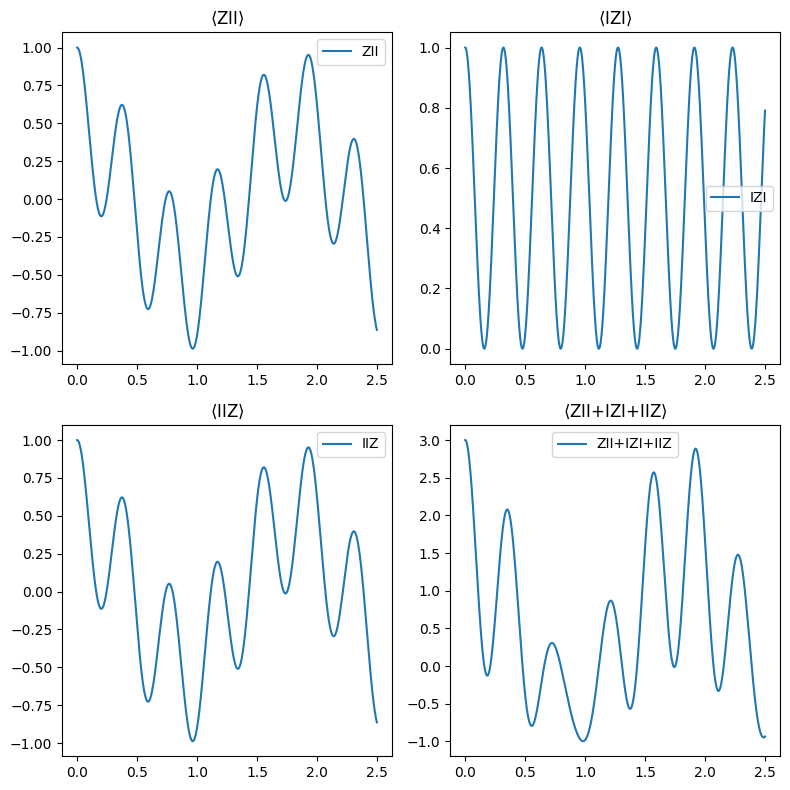

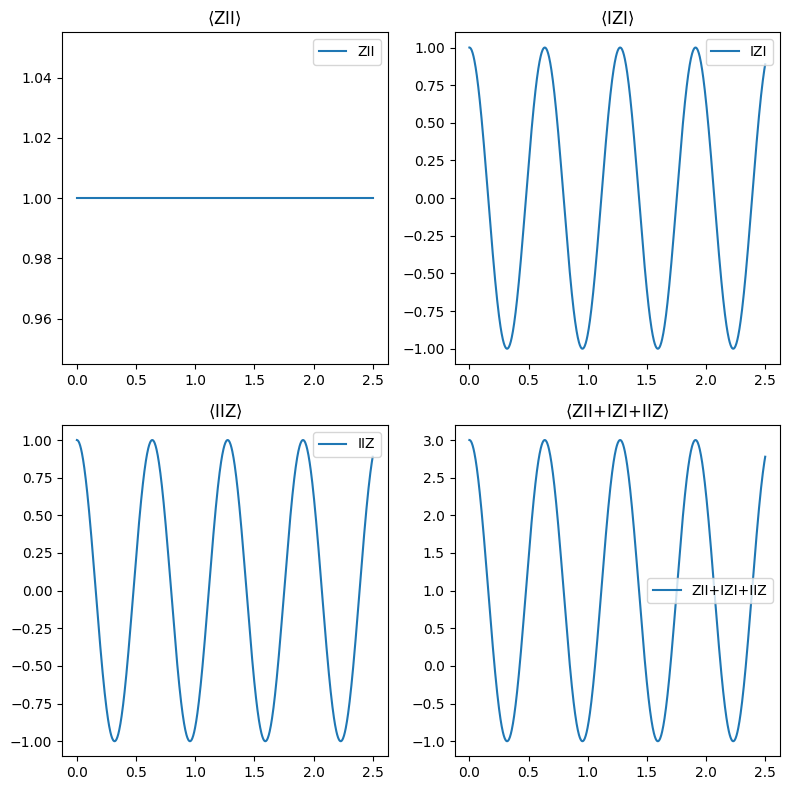

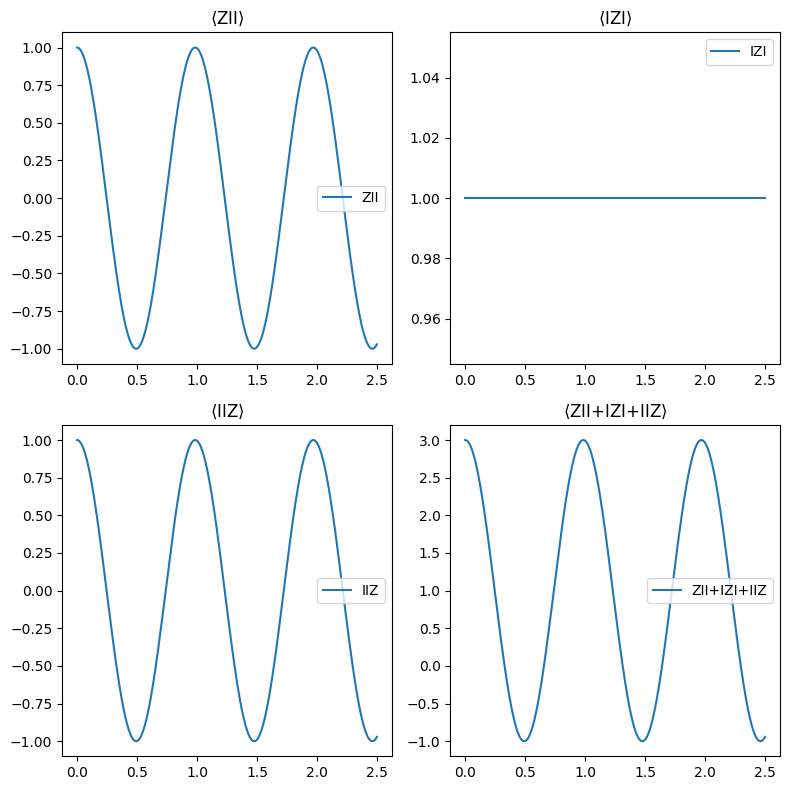

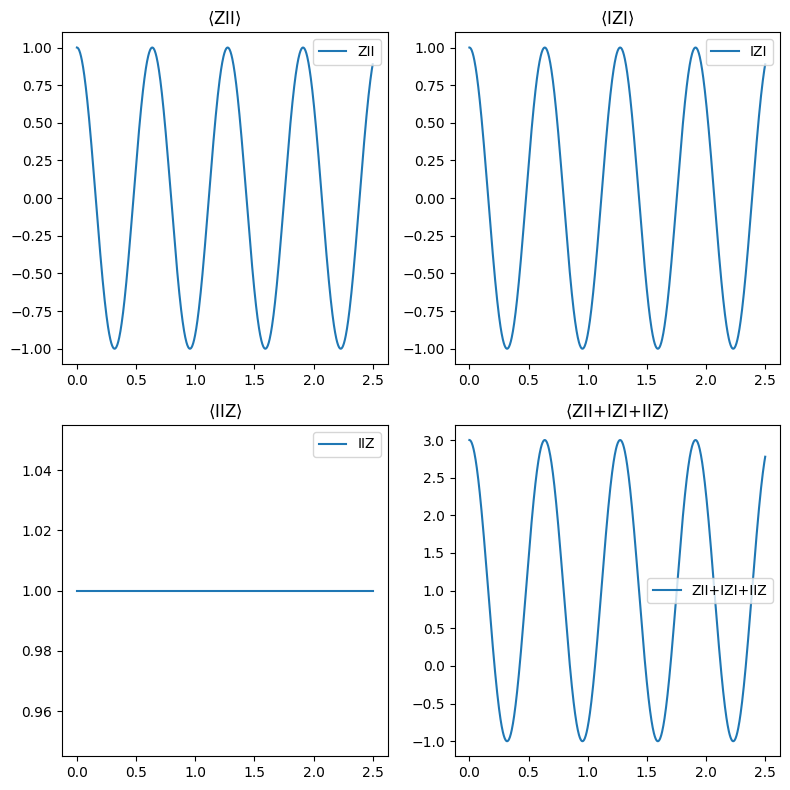

In [ ]:
H_int = HamiltonianXX(J_int,3)
H_1 = HamiltonianXX(J_1,3)
H_2 = HamiltonianXX(J_2,3)
H_3 = HamiltonianXX(J_3,3)

state_000 = grnd_state(3)
times = np.linspace(0,2.5,1000)

z = qt.sigmaz()
i2 = qt.qeye(2)


expZII = qt.tensor(z,i2,i2)
expIZI = qt.tensor(i2,z,i2)
expIIZ = qt.tensor(i2,i2,z)
mag_3 = expZII + expIZI + expIIZ
exps_3 = [expZII,expIZI,expIIZ,mag_3]
labels_3 = ['ZII','IZI','IIZ', "ZII+IZI+IIZ"]

dyn_template = qt.mesolve(H_int,state_000,times,[],exps_3)
shelved_1 = qt.mesolve(H_1,state_000,times,[],exps_3)
shelved_2 = qt.mesolve(H_2,state_000,times,[],exps_3)
shelved_3 = qt.mesolve(H_3,state_000,times,[],exps_3)


data = np.array([dyn_template,shelved_1,shelved_2,shelved_3])


for j in range(len(data)):

  rows = 2
  cols = 2

  fig, axes = plt.subplots(rows,cols,figsize=(8,8))

  axes = axes.flatten()

  for i in range(len(labels_3)):
      y = data[j].expect[i]
      axes[i].plot(times,y,label=labels_3[i])
      axes[i].legend()
      axes[i].set_title(r'$\langle$'+labels_3[i] + r'$\rangle$')

      #axes[i].plot(pulse_times,mean_spin_data[i])


  # Adjust the layout to prevent overlapping
  plt.tight_layout()

  # Show the plot
  plt.show()

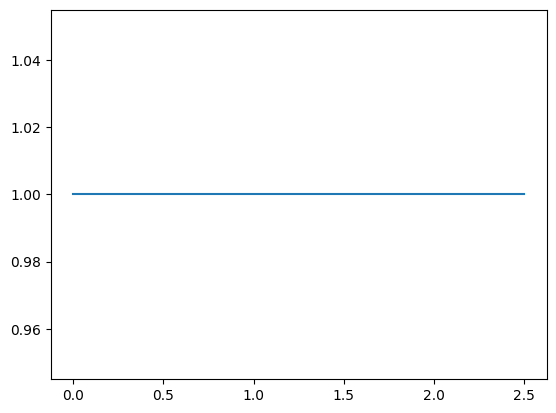

In [ ]:
shelved_1 = qt.mesolve(H_1,state_000,times,[],exps_3)


y = shelved_1.expect[0] #+ shelved_1.expect[1] #+ shelved_1.expect[2]
plt.plot(times,y)
plt.show()

[[0.        0.9001428]
 [0.9001428 0.       ]]


/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


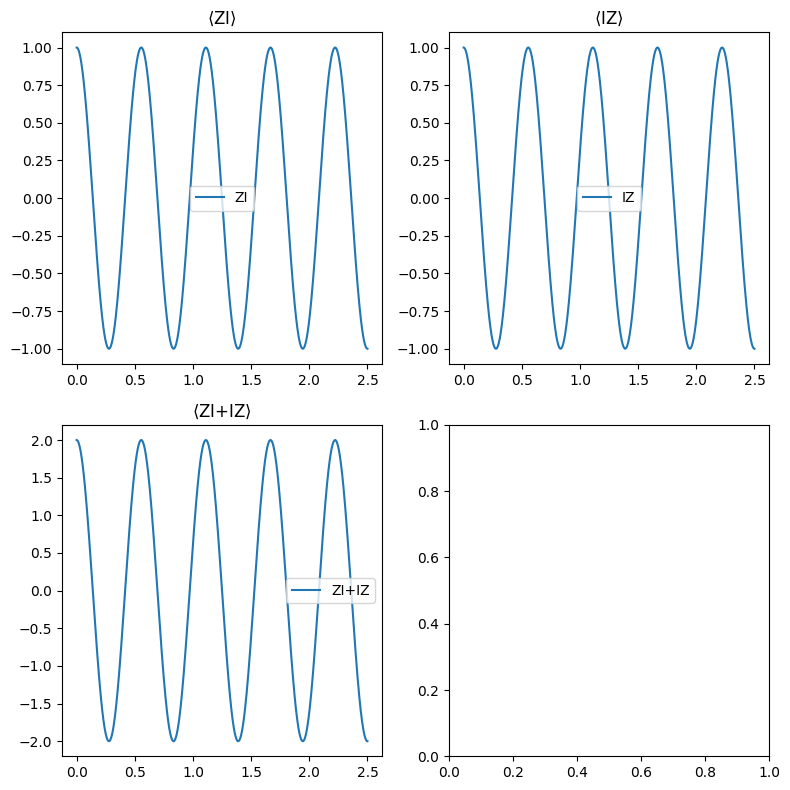

In [ ]:
N=2
evals, evects = eigensystem(fx,fz,N)
z = qt.sigmaz()
i2 = qt.qeye(2)

evals = evals*10**6 #convert to Hz
#choose mode to detune from
COM_freq = np.max(evals) #COM frequency
COM_freq_index = np.argmax(evals) #COM frequency index
detuning = 30e3 #Hz

Omegas = 200*np.ones(N)*1e3 #Hz
Omegas = .5*Omegas # split the rabi requencies bewteen the two beams

J_int = J(Omegas,evects,evals,COM_freq,detuning,recoil,N)
print(J_int)

H = HamiltonianXX(J_int,2)

#setup dynamics calulcation
times = np.linspace(0,2.5,1000)

state_00 = grnd_state(N)

expzi = qt.tensor(z,i2)
expiz = qt.tensor(i2,z)
mag_00 = expzi + expiz
exps_00 = [expzi,expiz,mag_00]
labels_00 = ['ZI','IZ', "ZI+IZ"]

two_ion_results = qt.mesolve(H,state_00,times,[],exps_00)


#plot results

rows = 2
cols = 2

fig, axes = plt.subplots(rows,cols,figsize=(8,8))

axes = axes.flatten()

for i in range(len(labels_00)):
    y = two_ion_results.expect[i]
    axes[i].plot(times,y,label=labels_00[i])
    axes[i].legend()
    axes[i].set_title(r'$\langle$'+labels_00[i] + r'$\rangle$')

    #axes[i].plot(pulse_times,mean_spin_data[i])


# Adjust the layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
H = HamiltonianXX(J_int,3)
state_init = grnd_state(3)
times = np.linspace(0,1.4,1000)

result = qt.mesolve(H, state_init, times, [], [])

In [ ]:
t = times

state000=[abs(qt.tensor(qt.basis(2,0),qt.basis(2,0),qt.basis(2,0)).dag()
*result.states[i])**2 for i in range(len(t))]

state001=[abs(qt.tensor(qt.basis(2,0),qt.basis(2,0),qt.basis(2,1)).dag()
*result.states[i])**2 for i in range(len(t))]

state010=[abs(qt.tensor(qt.basis(2,0),qt.basis(2,1),qt.basis(2,0)).dag()
*result.states[i])**2 for i in range(len(t))]

state011=[abs(qt.tensor(qt.basis(2,0),qt.basis(2,1),qt.basis(2,1)).dag()
*result.states[i])**2 for i in range(len(t))]

state100=[abs(qt.tensor(qt.basis(2,1),qt.basis(2,0),qt.basis(2,0)).dag()
*result.states[i])**2 for i in range(len(t))]

state101=[abs(qt.tensor(qt.basis(2,1),qt.basis(2,0),qt.basis(2,1)).dag()
*result.states[i])**2 for i in range(len(t))]

state110=[abs(qt.tensor(qt.basis(2,1),qt.basis(2,1),qt.basis(2,0)).dag()
*result.states[i])**2 for i in range(len(t))]

state111=[abs(qt.tensor(qt.basis(2,1),qt.basis(2,1),qt.basis(2,1)).dag()
*result.states[i])**2 for i in range(len(t))]

data = [state000,state001,state010,state011,state100,state101,
        state110,state111]



combs = np.array([
    [1, 1, 1],  # Up, Up, Up
    [1, 1, 0],  # Up, Up, Down
    [1, 0, 1],  # Up, Down, Up
    [1, 0, 0],  # Up, Down, Down
    [0, 1, 1],  # Down, Up, Up
    [0, 1, 0],  # Down, Up, Down
    [0, 0, 1],  # Down, Down, Up
    [0, 0, 0]   # Down, Down, Down
])

combs = np.flip(combs)

<ipython-input-13-2b5cc8213296>:11: MatplotlibDeprecationWarning: Passing label as a length 3 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  axes[i].plot(times,y,label=combs[i])


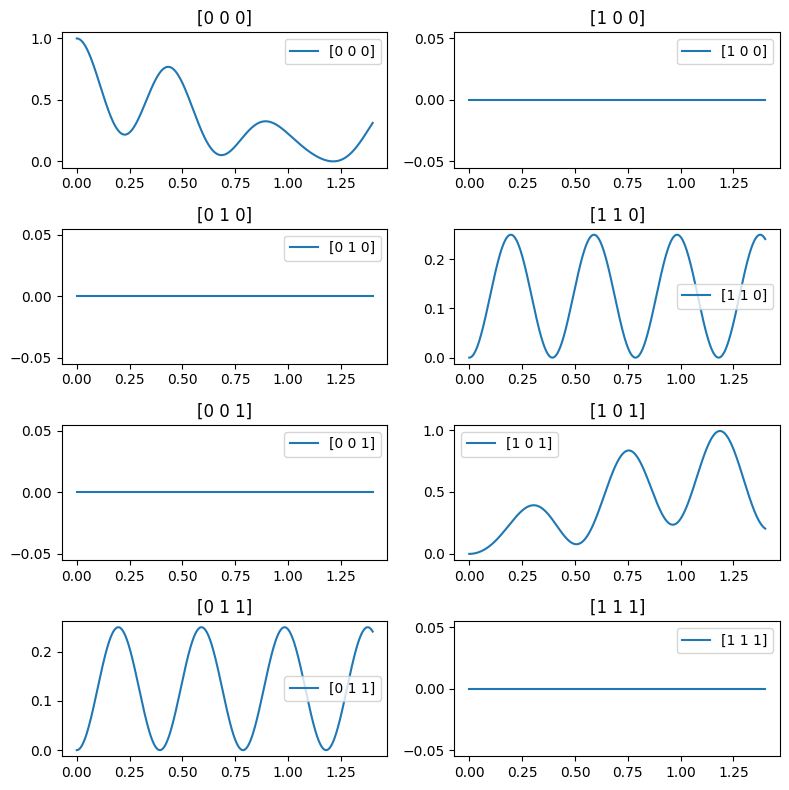

In [ ]:

rows = 4
cols = 2

fig, axes = plt.subplots(rows,cols,figsize=(8,8))

axes = axes.flatten()

for i in range(len(combs)):

    y = data[i]
    axes[i].plot(times,y,label=combs[i])
    axes[i].legend()
    axes[i].set_title(str(combs[i]))

    #axes[i].plot(pulse_times,mean_spin_data[i])


# Adjust the layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


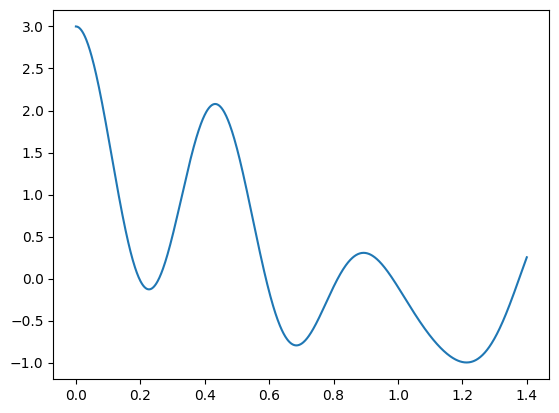

In [ ]:
i2 = qt.qeye(2)
z = qt.sigmaz()

M = qt.tensor(z,i2,i2) + qt.tensor(i2,z,i2) + qt.tensor(i2,i2,z)

result_M = qt.mesolve(H, state_init, times, [], [M])

plt.plot(times, result_M.expect[0])
plt.show()


/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


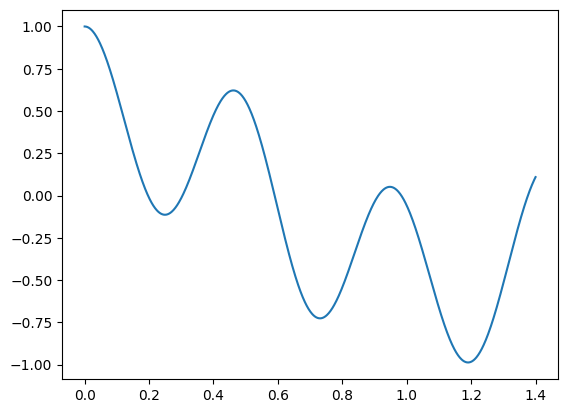

In [ ]:
i2 = qt.qeye(2)
z = qt.sigmaz()
x = qt.sigmax()

M = qt.tensor(z,i2,i2) + qt.tensor(i2,z,i2) + qt.tensor(i2,i2,z)

result_M = qt.mesolve(H, state_init, times, [], [])

state_dynamics = result_M.states


exp_val = np.array([state_dynamics[i].dag() * (qt.tensor(z,i2,i2)) * state_dynamics[i] for i in range (len(times))])
plt.plot(times,exp_val)
plt.show()

# Some qutip examples

In [ ]:
J_F = J

X = qt.sigmax()
I  = qt.qeye(2)

H_F = 2*np.pi*(J[0][1] * qt.tensor(X,X))


#initial state
state1 = qt.basis(2,0)
state2 = qt.basis(2,0)
state_int = qt.tensor(state1,state2)

times = np.linspace(0,1.4,1000)

In [ ]:
#time evolution

results_F = qt.mesolve(H_F, state_int, times, [], [])


In [ ]:
t = times

state00_F=[abs(qt.tensor(qt.basis(2,0),qt.basis(2,0)).dag()
*results_F.states[i])**2 for i in range(len(t))]
state01_F=[abs(qt.tensor(qt.basis(2,0),qt.basis(2,1)).dag()
*results_F.states[i])**2 for i in range(len(t))]
state10_F = [abs(qt.tensor(qt.basis(2,1),qt.basis(2,0)).dag()
*results_F.states[i])**2 for i in range(len(t))]
state11_F = [abs(qt.tensor(qt.basis(2,1),qt.basis(2,1)).dag()
*results_F.states[i])**2 for i in range(len(t))]





data_F = [state00_F,state01_F,state10_F,state11_F]


combs  = ['00','01','10','11']


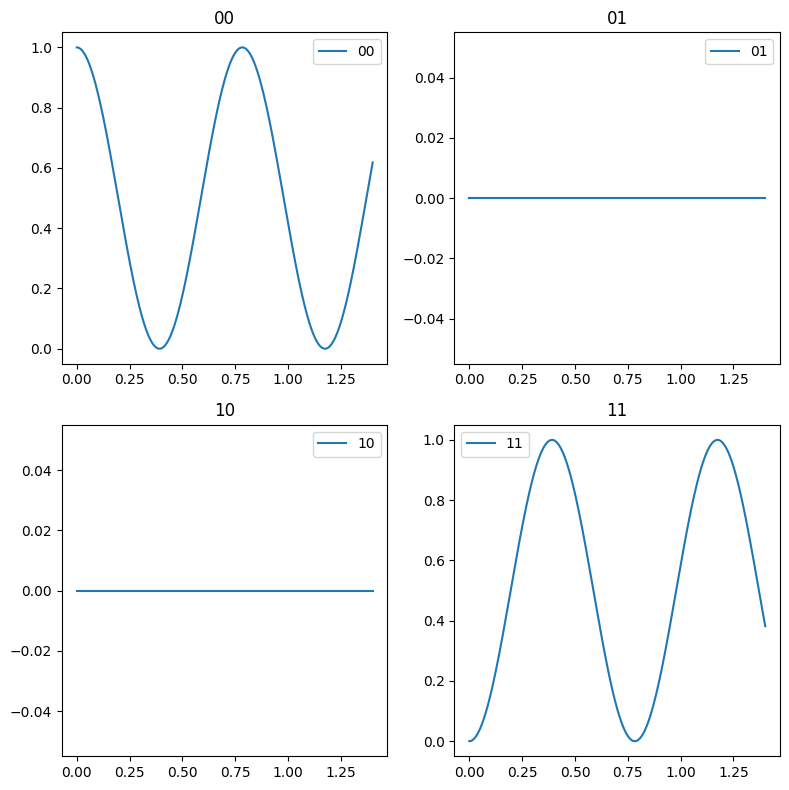

In [ ]:

rows = 2
cols = 2

fig, axes = plt.subplots(rows,cols,figsize=(8,8))

axes = axes.flatten()

for i in range(len(combs)):

    y = data_P[i]
    axes[i].plot(times,y,label=combs[i])
    axes[i].legend()
    axes[i].set_title(str(combs[i]))

    #axes[i].plot(pulse_times,mean_spin_data[i])


# Adjust the layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

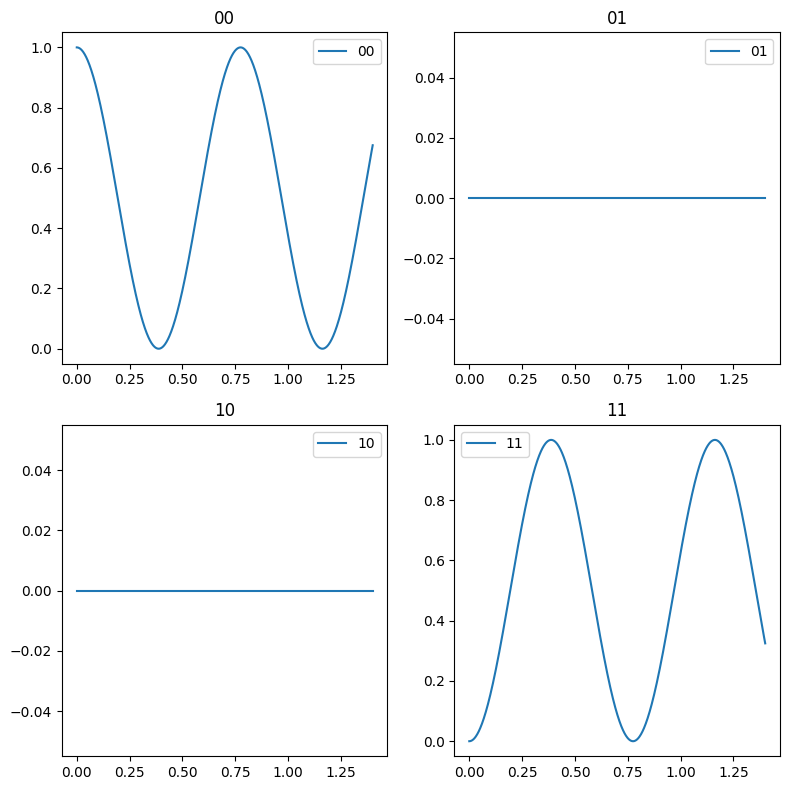

In [ ]:

rows = 2
cols = 2

fig, axes = plt.subplots(rows,cols,figsize=(8,8))

axes = axes.flatten()

for i in range(len(combs)):

    y = data_F[i]
    axes[i].plot(times,y,label=combs[i])
    axes[i].legend()
    axes[i].set_title(str(combs[i]))

    #axes[i].plot(pulse_times,mean_spin_data[i])


# Adjust the layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

## Time evolution 3 ion test

In [ ]:
#write down the Hamiltonian
X = qt.sigmax()
I  = qt.qeye(2)

#J = np.array([[0,.598236,.360169],[.598236,0,.598236],[.360169,.598236,0]])

H = 2*np.pi*(J[0][1] * qt.tensor(X,X,I)+J[0][2]*qt.tensor(X,I,X)+J[1][2]*qt.tensor(I,X,X))


#initial state
state1 = qt.basis(2,0)
state2 = qt.basis(2,0)
state3 = qt.basis(2,0)
state_int = qt.tensor(state1,state2,state3)

#times
pulse_times = np.array([1,52.69,104.38,156.07,207.76,259.45,311.14,362.83,414.52, \
                        466.21,517.9,569.59,621.28,672.97,724.66,776.34,828.03,879.72,\
                        931.41,983.1,1034.79,1086.48,1138.17,1189.86,1241.55,1293.24, \
                        344.93,1396.62,1448.31,1500])

times = np.linspace(0,1.4,1000)

In [ ]:
result = qt.mesolve(H, state_int, times, [], [])

In [ ]:
t = times

state000=[abs(qt.tensor(qt.basis(2,0),qt.basis(2,0),qt.basis(2,0)).dag()
*result.states[i])**2 for i in range(len(t))]

state001=[abs(qt.tensor(qt.basis(2,0),qt.basis(2,0),qt.basis(2,1)).dag()
*result.states[i])**2 for i in range(len(t))]

state010=[abs(qt.tensor(qt.basis(2,0),qt.basis(2,1),qt.basis(2,0)).dag()
*result.states[i])**2 for i in range(len(t))]

state011=[abs(qt.tensor(qt.basis(2,0),qt.basis(2,1),qt.basis(2,1)).dag()
*result.states[i])**2 for i in range(len(t))]

state100=[abs(qt.tensor(qt.basis(2,1),qt.basis(2,0),qt.basis(2,0)).dag()
*result.states[i])**2 for i in range(len(t))]

state101=[abs(qt.tensor(qt.basis(2,1),qt.basis(2,0),qt.basis(2,1)).dag()
*result.states[i])**2 for i in range(len(t))]

state110=[abs(qt.tensor(qt.basis(2,1),qt.basis(2,1),qt.basis(2,0)).dag()
*result.states[i])**2 for i in range(len(t))]

state111=[abs(qt.tensor(qt.basis(2,1),qt.basis(2,1),qt.basis(2,1)).dag()
*result.states[i])**2 for i in range(len(t))]

data = [state000,state001,state010,state011,state100,state101,
        state110,state111]



combinations = np.array([
    [1, 1, 1],  # Up, Up, Up
    [1, 1, 0],  # Up, Up, Down
    [1, 0, 1],  # Up, Down, Up
    [1, 0, 0],  # Up, Down, Down
    [0, 1, 1],  # Down, Up, Up
    [0, 1, 0],  # Down, Up, Down
    [0, 0, 1],  # Down, Down, Up
    [0, 0, 0]   # Down, Down, Down
])

combinations = np.flip(combinations)

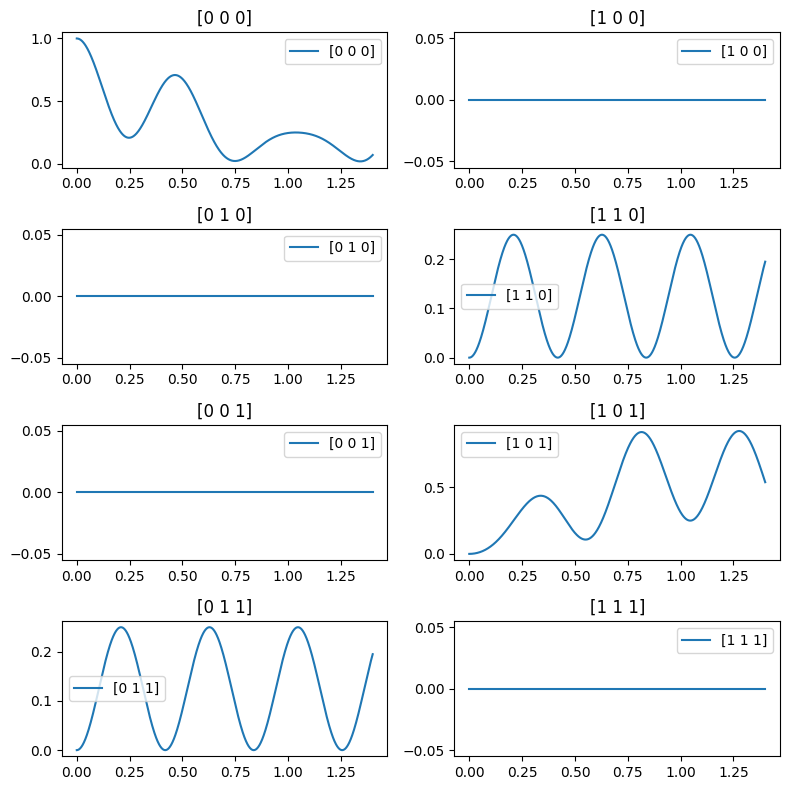

In [ ]:

rows = 4
cols = 2

fig, axes = plt.subplots(rows,cols,figsize=(8,8))

axes = axes.flatten()

for i in range(len(combinations)):

    y = data[i]
    axes[i].plot(times,y,label=combinations[i])
    axes[i].legend()
    axes[i].set_title(str(combinations[i]))

    #axes[i].plot(pulse_times,mean_spin_data[i])


# Adjust the layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()